In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import metrics
from sklearn.metrics import (roc_auc_score, precision_score, average_precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error, roc_curve, auc, classification_report,auc,confusion_matrix,matthews_corrcoef)
from sklearn import logger
from sklearn.datasets import make_blobs,make_multilabel_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KernelCenterer,LabelEncoder, MinMaxScaler, Normalizer, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.manifold import TSNE
import time
from sklearn.metrics import confusion_matrix,classification_report
import scipy as sp
from scipy.linalg import svd,null_space
import os
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix as sp
import math
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting tools
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:

# Hàm	Độ phức tạp tính toán	Bộ nhớ cần
# preprocess_data_OC	O(n⋅d²)	O(n⋅d²)
# clusterr	O(n⋅d⋅k⋅iters)	O(n⋅d)
# nullspace	O(d³)	O(d²)
# gram_schmidt	O(d³)	O(d²)
# minimum_distance	O(n⋅m⋅d)	O(n⋅m)
# distance_vector	O(n⋅m⋅d)	O(n⋅m)
# calculate_NPD	O(d³)	O(d²)
# learn	O(n²⋅d)	O(n²)



alpha = 0.9 

In [3]:

def preprocess_data_noise(train_data, test_data, noise_percentage=10):
  
    print("..............................Data Overview................................")
    print("Train Data Shape:", train_data.shape)
    print("Test Data Shape:", test_data.shape)
    
    # Convert to numpy arrays for easier manipulation
    X_train_total = train_data.iloc[:, :-1].to_numpy()
    y_train_total = train_data.iloc[:, -1].to_numpy()

    # Separate the samples with label 0
    X_train = X_train_total[y_train_total == 0]
    y_train = y_train_total[y_train_total == 0]

    print("Train Data Labels [0]:", np.unique(y_train))

    # Calculate how many samples to add noise to based on the provided percentage
    n_samples = X_train.shape[0]
    noise_samples_count = int(n_samples * (noise_percentage / 100))

    # Get the samples with label 1 (for generating noise)
    X_train_noise = X_train_total[y_train_total == 1]
    
    # Randomly select noise_samples_count from X_train_noise
    noisy_indices = np.random.choice(X_train_noise.shape[0], size=noise_samples_count, replace=False)
    X_train_noise = X_train_noise[noisy_indices]
    
    # Add the noisy samples to the training set
    X_train = np.vstack((X_train, X_train_noise))
    y_train = np.concatenate((y_train, np.ones(X_train_noise.shape[0])))
    print(y_train) 
    
    # Prepare test data
    X_test = test_data.iloc[:, :-1].to_numpy()
    y_test = test_data.iloc[:, -1].to_numpy()

    # Print the new size of training data
    n_samples = X_train.shape[0]
    n_features = X_train.shape[1]
    print("Number of samples after adding noise:", n_samples)
    print("Number of features:", n_features)

    return X_train, y_train, X_test, y_test



from sklearn.mixture import GaussianMixture

def cluster_kmeans(data, initial_k):
    print("Starting K-Means clustering...")

    # Thực hiện K-Means clustering với số cụm initial_k
    kmeans = KMeans(n_clusters=initial_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)

    # Gán nhãn cụm vào biến labels
    labels = cluster_labels

    # Sắp xếp dữ liệu theo nhãn cụm
    sorted_indices = np.argsort(labels)
    sorted_data = data[sorted_indices]
    sorted_labels = labels[sorted_indices]

    print("Final number of clusters:", len(np.unique(sorted_labels)))
    return sorted_data, sorted_labels

In [4]:
def nullspace(A):
    _, s, vh = np.linalg.svd(A)
    null_mask = np.isclose(s, 0)
    null_space = vh[null_mask].T
    return null_space


def minimum_distance( A, B):
        """
        Compute the minimum Euclidean distance from each point in A to all points in B.
        
        Parameters:
        - A (ndarray): Set of points (N_A, d).
        - B (ndarray): Set of points (N_B, d).
        
        Returns:
        - min_distances (ndarray): Minimum distances from each point in A to the nearest point in B.
        """
        A = np.asarray(A)
        B = np.asarray(B)
        
        # Initialize an array for storing minimum distances
        min_distances = np.empty(A.shape[0], dtype=np.float64)
        
        # Iterate over each point in A and calculate minimum distance to points in B
        for i, a in enumerate(A):
            distances = cdist([a], B, metric='euclidean')  # Compute all pairwise distances
            min_distances[i] = np.min(distances)  # Store minimum distance
        
        return min_distances   

def distance_vector(point_X, point_Y):
    """
    Calculate pairwise Euclidean distance between two sets of points.
    
    Args:
        point_X (ndarray): Array of shape (N_train, d) where N_train is the number of training samples and d is the number of features.
        point_Y (ndarray): Array of shape (N_test, d) where N_test is the number of test samples and d is the number of features.
        
    Returns:
        ndarray: Distance matrix of shape (N_test, N_train) containing Euclidean distances between each pair of points.
    """
    print( 'Complexity of calculate: ', point_X )
    # Compute squared norms for each point
    norm_X = np.sum(point_X**2, axis=1)  # (N_train,)
    norm_Y = np.sum(point_Y**2, axis=1)  # (N_test,)
    
    # Compute the dot product between the two sets of points
    dot_product = np.dot(point_Y, point_X.T)  # (N_test, N_train)
    
    # Apply Euclidean distance formula
    distance = np.sqrt(abs(norm_Y[:, np.newaxis] + norm_X[np.newaxis, :] - 2 * dot_product))
    return distance



def calculate_NPD(X,y):
    print("Begin calculating NPD --------------")
    X = X.T
    print('shape of X', X.shape)
    c = len(np.unique(y))  # Số lớp
    d, N = X.shape  # Số đặc trưng và số mẫu
    # Tính trung bình toàn cục và tạo ma trận P_t với zero-mean
    mean_total = np.mean(X, axis=1, keepdims=True)
    P_t = X - mean_total  # P_t là ma trận zero-mean có kích thước d x N
    
    # Tính P_w cho từng lớp
    P_w = np.zeros_like(X)
    for i in range(c):
        class_mean = np.mean(X[:, y == i], axis=1, keepdims=True)
        P_w[:, y == i] = X[:, y == i] - class_mean  # Tạo ma trận P_w có kích thước d x N
        
    # Tính ma trận phương sai S_w và S_t
    S_w = np.dot(P_w, P_w.T) / N  # S_w là d x d
    S_t = np.dot(P_t, P_t.T) / N  # S_t là d x d

    print( "rank sw st :", np.linalg.matrix_rank(S_t) , np.linalg.matrix_rank(S_w)) 
    print( "rank sw st :", np.linalg.matrix_rank(P_t) , np.linalg.matrix_rank(P_w)) 

    
    U, S, Vt = np.linalg.svd(P_t, full_matrices=False)
    Q = U
    B = nullspace(Q.T @ S_w @ Q)
    W = Q @ B  # W có kích thước d x (c - 1)

    # In kết quả
    print("N =", N,  "  d =", d, "   c =", c )
    print("P_w : d x N =", P_w.shape)  # d x N
    print("P_t : d x N =", P_t.shape)  # d x N
    print("S_w : d x d =", S_w.shape)  # d x d
    print("S_t : d x d =", S_t.shape)  # d x d
    print("Q   : d x N =", Q.shape)     # d x r
    print("B   : N x L =", B.shape)     # r x L
    print("W   : d x L =", W.shape)     # d x L
    return W    

    

def BruteForce_Threshold(y_true, y_prob, minth=0.0, maxth=1.0, num_thresholds=1000):
    """
    Finds the best classification threshold for a binary model using brute force search.

    Args:
        y_true (ndarray): True labels (0 or 1), shape (n_samples,).
        y_prob (ndarray): Predicted probabilities for class 1, shape (n_samples,).
        minth (float, optional): Minimum threshold value. Default is 0.0.
        maxth (float, optional): Maximum threshold value. Default is 1.0.
        num_thresholds (int, optional): Number of threshold values to search. Default is 1000.

    Returns:
        dict: Dictionary containing the best threshold for each evaluation metric.
    """
    thresholds = np.linspace(minth, maxth, num_thresholds)  # Generate candidate thresholds

    # Initialize best metrics
    best_results = {
        "accuracy": (0, 0),  # (best_threshold, best_score)
        "f1": (0, 0),
        "mcc": (0, 0),
        "auc_roc": (0, 0),
        "auc_pr": (0, 0)
    }

    return best_results 
    for threshold in thresholds:
        y_pred = (y_prob[:,1] >= threshold).astype(int)

        # Compute evaluation metrics
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        mcc = matthews_corrcoef(y_true, y_pred)
        auc_roc = roc_auc_score(y_true, y_prob[:, 1])
        auc_pr = average_precision_score(y_true, y_prob[:, 1])

        # Update best threshold for each metric
        if acc > best_results["accuracy"][1]:
            best_results["accuracy"] = (threshold, acc)
        if f1 > best_results["f1"][1]:
            best_results["f1"] = (threshold, f1)
        if mcc > best_results["mcc"][1]:
            best_results["mcc"] = (threshold, mcc)
        if auc_roc > best_results["auc_roc"][1]:
            best_results["auc_roc"] = (threshold, auc_roc)
        if auc_pr > best_results["auc_pr"][1]:
            best_results["auc_pr"] = (threshold, auc_pr)
    return best_results


def learn( npd, X_train, y_train , X_test, t0):
    '''
    X_train n1, d 

    C: n * n * d 
    '''
    t1 = time.time()
    null_point_X = (sp(X_train).dot(sp(npd))).toarray()
    null_point_X_test = (sp(X_test).dot(sp(npd))).toarray()  

    train_score_tmp = distance_vector(null_point_X, null_point_X)
    for i in range(len(train_score_tmp)):
        train_score_tmp[i , i] = 1e9                                                      
    train_score = np.amin(train_score_tmp, axis=1)
    
    y_score = minimum_distance(null_point_X_test, null_point_X)
    y_proba = np.zeros((len(y_score), 2))
    y_proba[:, 1] = np.minimum(y_score / np.max(train_score), 1)                         
    y_proba[:, 0] = 1 - y_proba[:, 1]                                                     # Probability for class 0
    y_proba = np.nan_to_num(y_proba, nan=1.0)
    y_predict = (y_proba[:, 1] > 0.001).astype(int) 
    t2 = time.time()
    print("...............................Timing Model................................")
    print("Time train:", t1-t0)
    print("Time test:" , t2-t1)
    return y_proba, t1, t2  
    


from sklearn.metrics import roc_curve
def Model_evaluating(y_true, y_scores):
    """
    Evaluate the model using threshold derived from ROC curve (Youden’s J statistic).
    
    Args:
        y_true (ndarray): True labels (binary: 0 or 1).
        y_scores (ndarray): Predicted probabilities for each class (2D array).
        
    Returns:
        list: List of evaluation metrics [AUC, AUCPR, Accuracy, MCC, F1, Precision, Recall].
    """
    print("..............................Report Parameter...............................")
    
    # Lấy xác suất cho lớp dương (lớp 1)
    y_prob = y_scores[:, 1]
    
    # Tính ROC và threshold tối ưu theo Youden’s J statistic
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    print("Optimal threshold (Youden's J):", optimal_threshold)

    # Dự đoán nhãn với threshold tối ưu
    y_predict_optimal = (y_prob >= optimal_threshold).astype(int)

    # Tính các chỉ số đánh giá
    mcc = matthews_corrcoef(y_true, y_predict_optimal)
    f1 = f1_score(y_true, y_predict_optimal)
    ppv = precision_score(y_true, y_predict_optimal)
    recall = recall_score(y_true, y_predict_optimal)
    accuracy = accuracy_score(y_true, y_predict_optimal)
    auc = roc_auc_score(y_true, y_prob)
    aucpr = average_precision_score(y_true, y_prob)
    
    # In ra các kết quả
    print("AUCROC:", auc * 100)
    print("AUCPR:", aucpr * 100)
    print("Accuracy:", accuracy * 100)
    print("MCC:", mcc)
    print("F1 score:", f1)
    print("PPV (Precision):", ppv)
    print("TPR (Recall):", recall)

    return y_predict_optimal  # [auc * 100, aucpr * 100, accuracy * 100, mcc, f1, ppv, recall]



In [5]:
# X_train, y_train, X_test, y_test = preprocess_data_OC(df2, df1)

# X_total = np.vstack((X_train, X_test))
# unique_rows = np.unique(X_total, axis=0)

# print("Số dòng trong X_total:", X_total.shape[0])   # Output: 5
# print("Số dòng khác nhau:", unique_rows.shape[0])  

In [6]:

import pandas as pd

columns = ["scaler","nCluster", 'noise_percentage', "AUCROC", "AUCPR", "Accuracy", "MCC", "F1 Score",
           "Precision", "Recall", "Time Train", "Time Test"]

import cProfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def function(df1, df2, scaler, noise, ncluster):
    X_train0, y_train0, X_test, y_test = preprocess_data_noise(df1, df2, noise)

    imputer = SimpleImputer(strategy="mean") 
    X_train0[np.isinf(X_train0)] = np.nan  
    X_train0 = imputer.fit_transform(X_train0)

    X_train, y_train = cluster_kmeans(X_train0, ncluster)


    t5 = time.time()     
    npd = calculate_NPD(X_train, y_train)
    t4 = time.time() 

    print(" time to calculate NPD: " , t4 - t5)  

    t0 = time.time()
    y_proba, t1, t2 = learn(npd, X_train, y_train, X_test, y_test)
    y_predict = Model_evaluating(y_test, y_proba)

    return y_test, y_predict



--------------------------------------------------
Running for BoTIoT
--------------------------------------------------
..............................Data Overview................................
Train Data Shape: (66929, 27)
Test Data Shape: (28685, 27)
Train Data Labels [0]: [0]
[0. 0. 0. ... 0. 0. 0.]
Number of samples after adding noise: 6372
Number of features: 26
Starting K-Means clustering...
Final number of clusters: 1
Begin calculating NPD --------------
shape of X (26, 6372)
rank sw st : 17 17
rank sw st : 24 24
N = 6372   d = 26    c = 1
P_w : d x N = (26, 6372)
P_t : d x N = (26, 6372)
S_w : d x d = (26, 26)
S_t : d x d = (26, 26)
Q   : d x N = (26, 26)
B   : N x L = (26, 22)
W   : d x L = (26, 22)
 time to calculate NPD:  0.01575779914855957
Complexity of calculate:  [[-1.22376453e-02 -2.03087086e-04 -1.59902218e-03 ...  5.28894399e-09
   2.17374608e-10  4.91630410e-11]
 [-1.23566519e-02 -2.00474864e-04 -1.59179742e-03 ...  5.31279733e-09
   2.17571285e-10  4.92276534e-1

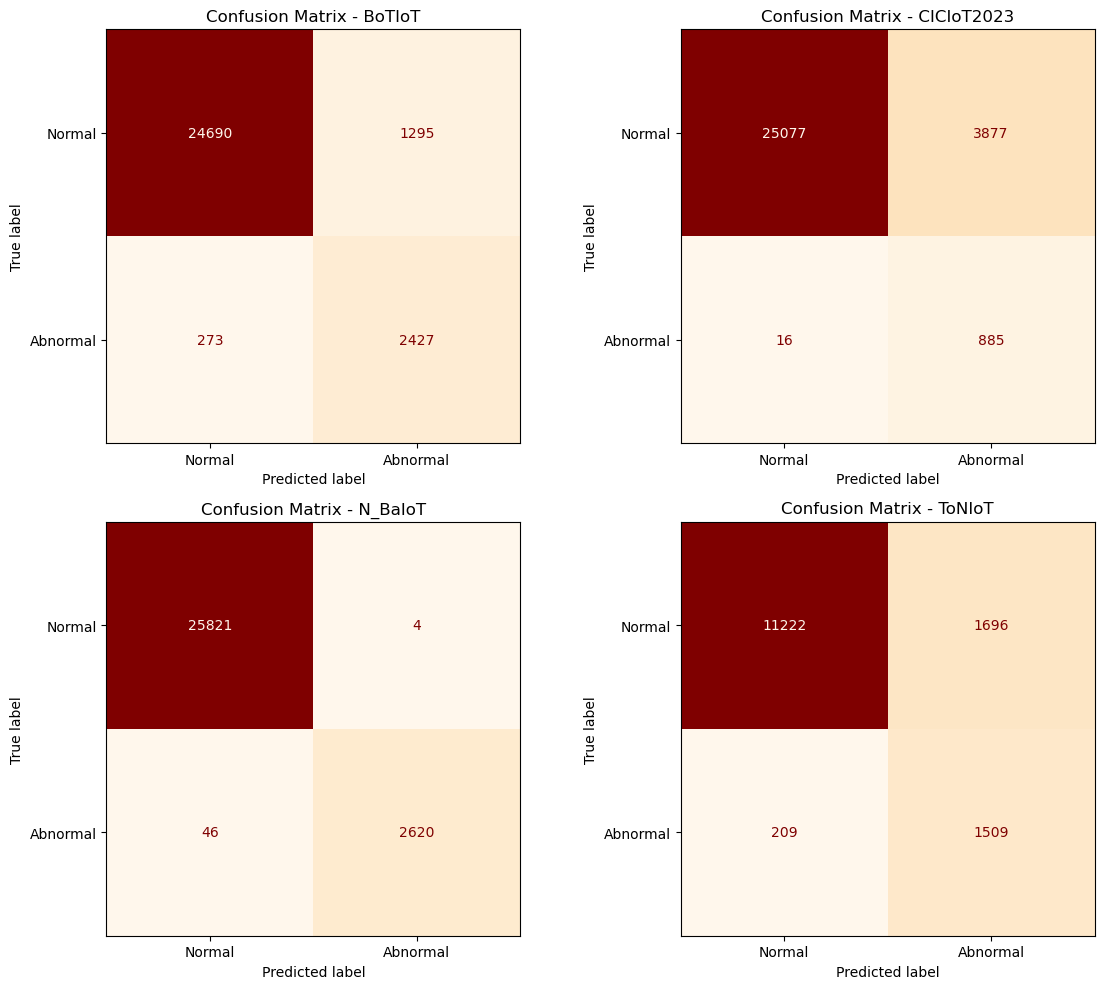

In [7]:
# import cProfile
import pstats    

# dataset_prefixes =  ['N_BaIoT_dataloader.csv']
dataset_prefixes =  [ 'BoTIoT', 'CICIoT2023','N_BaIoT', 'ToNIoT' ]

setting = { # C means the number of cluster , Sc is scaler   
    "BoTIoT": { 
        "C" : 1, 
        "Sc" : "Normalizer" 
    }, 
    "CICIoT2023": {
        "C" : 139, 
        "Sc" : "MinMaxScaler" 
    }, 
    "N_BaIoT": {
        "C": 184, 
        "Sc": "MinMaxScaler"
    },
    "ToNIoT": {
        "C": 301, 
        "Sc": "QuantileTransformer" 
    }
    
}
confusion_matrix_data = {
    "BoTIoT": {
        "y_true": [1, 1, 1, 0, 0, 1, 0, 0, 1],        # ví dụ
        "y_pred": [1, 1, 1, 0, 0, 1, 1, 0, 0]
    },
    "CICIoT2023": {
        "y_true": [1, 0, 0, 1, 1, 1, 0, 0, 1],
        "y_pred": [1, 0, 1, 1, 0, 1, 0, 0, 1]
    },
    "N_BaIoT": {
        "y_true": [1, 1, 1, 1, 0, 0, 0, 1],
        "y_pred": [1, 1, 1, 1, 0, 0, 0, 1]
    },
    "ToNIoT": {
        "y_true": [1, 1, 0, 0, 1, 0, 1, 0],
        "y_pred": [1, 1, 0, 1, 1, 0, 1, 0]
    }
}

for prefix in dataset_prefixes:
    print(f"\n{'-'*50}\nRunning for {prefix}\n{'-'*50}")
    
    scaler = setting[prefix]["Sc"]
    ncluster = setting[prefix]["C"]
    

    # Tải dữ liệu
    train_file = f'Datascaled/NoiseOCData/Train_{scaler}_data_{prefix}.csv'
    test_file = f'Datascaled/NoiseOCData/Test_{scaler}_data_{prefix}.csv'

    df_train = pd.read_csv(train_file).dropna()
    df_test = pd.read_csv(test_file).dropna()

    df_full = pd.concat([df_train, df_test], ignore_index=True)
    df_train_new, df_test_new = train_test_split(df_full, test_size=0.3, random_state=42)

    y_true, y_pred = function(df_train_new, df_test_new, scaler, noise=0, ncluster=ncluster)

    confusion_matrix_data[prefix] = {
        "y_true": y_true,
        "y_pred": y_pred
    }



# plot confusion matrix 

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for i, (name, data) in enumerate(confusion_matrix_data.items()):
    cm = confusion_matrix(data["y_true"], data["y_pred"], labels=[1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
    disp.plot(ax=axs[i], cmap="OrRd", colorbar=False)
    axs[i].set_title(f"Confusion Matrix - {name}")

plt.tight_layout()

# plt.savefig("confusion_matrices.png", dpi=300)  # Có thể đổi tên, định dạng, hoặc thêm bbox_inches="tight" nếu cần

plt.show()
